In [1]:
import pandas as pd
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

DESCRIPTIVES

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


(array([ 591.,  649., 2089., 1976., 1350.,  893.,  536.,  294.,  106.,
          30.]),
 array([ 0. ,  7.9, 15.8, 23.7, 31.6, 39.5, 47.4, 55.3, 63.2, 71.1, 79. ]),
 <BarContainer object of 10 artists>)

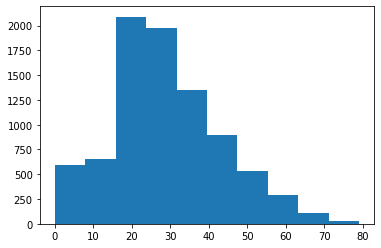

In [4]:
plt.hist(df_train.Age)

In [5]:
for column in df_train.columns[1:]:
    values = df_train[column].value_counts()
    if len(values) < 5:
        print(column, dict(values))
    else:
        print(f'{column} has {len(values)} different values')

HomePlanet {'Earth': 4602, 'Europa': 2131, 'Mars': 1759}
CryoSleep {False: 5439, True: 3037}
Cabin has 6560 different values
Destination {'TRAPPIST-1e': 5915, '55 Cancri e': 1800, 'PSO J318.5-22': 796}
Age has 80 different values
VIP {False: 8291, True: 199}
RoomService has 1273 different values
FoodCourt has 1507 different values
ShoppingMall has 1115 different values
Spa has 1327 different values
VRDeck has 1306 different values
Name has 8473 different values
Transported {True: 4378, False: 4315}


PREPROCESSING

In [6]:
def fillna_with_mode(df):
    for column in df.columns:
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)
        
    return df

def replace_with_numbers(df, column_names):
    for column in column_names:
        unique_values = sorted(df[column].unique())
        value_to_number = {value: i for i, value in enumerate(unique_values)}
        df[column] = df[column].replace(value_to_number)
    
    return df

def get_non_numeric_columns(df):
    non_numeric_columns = []
    
    for column in df.columns:
        if not pd.api.types.is_numeric_dtype(df[column]) or pd.api.types.is_bool_dtype(df[column]):
            non_numeric_columns.append(column)

    return non_numeric_columns

In [7]:
non_numeric_columns = get_non_numeric_columns(df_train)
del non_numeric_columns[-2]
non_numeric_columns

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Transported']

In [8]:
df_test = fillna_with_mode(df_test)
df_train = fillna_with_mode(df_train)

df_test = replace_with_numbers(df_test, non_numeric_columns[:-1])
df_train = replace_with_numbers(df_train, non_numeric_columns)

In [58]:
def one_hot_encode(df, column_name):
    one_hot = pd.get_dummies(df[column_name], prefix=column_name)
    return pd.concat([df, one_hot], axis=1).drop(column_name, axis=1)

def multiple_one_hot_encode(df, column_names):
    for column in column_names:
        df = one_hot_encode(df, column)
    return df

In [59]:
df_test = multiple_one_hot_encode(df_test, ['HomePlanet', 'Destination'])
df_train = multiple_one_hot_encode(df_train, ['HomePlanet', 'Destination'])


In [64]:
df_train[:5]

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_0,HomePlanet_1,HomePlanet_2,Destination_0,Destination_1,Destination_2
0,0,0,149,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,1,0,0,0,1
1,1,0,2184,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,0,0,0,0,1
2,2,0,1,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1,0,0,0,1
3,3,0,1,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,1,0,0,0,1
4,4,0,2186,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1,0,0,0,0,1


In [78]:
features = []
for item in df_train.columns[1:10]:
    features.append(item)
for item in df_train.columns[12:]:
    features.append(item)

features

['CryoSleep',
 'Cabin',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'HomePlanet_0',
 'HomePlanet_1',
 'HomePlanet_2',
 'Destination_0',
 'Destination_1',
 'Destination_2']

In [81]:
X = df_train[features]
y = df_train['Transported']

In [150]:
X[:5]

,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_0,HomePlanet_1,HomePlanet_2,Destination_0,Destination_1,Destination_2
0,0,149,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1
1,0,2184,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,0,0,0,1
2,0,1,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,0,0,0,1
3,0,1,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,1,0,0,0,1
4,0,2186,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0,0,0,0,1


SHALOW PREDICTIONS

In [11]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True)

In [82]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

clf_SVC = SVC(C=100)
cvs = cross_val_score(clf_SVC, X, y, cv=kfold)
cvs.mean(), cvs.std()

(0.7878735381563284, 0.011890136811951106)

In [85]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(max_depth=8)
cvs = cross_val_score(clf_RF, X, y, cv=kfold)
cvs.mean(), cvs.std()

(0.7950063228274917, 0.012044625458987037)

DEEP PREDICTIONS

In [113]:
X_dl = torch.tensor(X.iloc[:].values).float()
y_dl = torch.tensor(y.iloc[:].values).float()

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dl, y_dl, test_size=0.2, random_state=42)

In [296]:
from torch import nn

class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(15, 60)
        self.act1 = nn.Tanh()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
    # def __init__(self):
    #     super().__init__()
    #     self.hidden = nn.Linear(15, 64)
    #     self.relu = nn.ReLU()
    #     self.dropout = nn.Dropout(p=0.3)
    #     self.layer_1 = nn.Linear(64, 32)
    #     self.output = nn.Linear(32, 1)
    #     self.sigmoid = nn.Sigmoid()
        
    # def forward(self, x):
    #     x = self.sigmoid(self.hidden(x))
    #     x = self.sigmoid(self.layer_1(x))
    #     x = self.sigmoid(self.output(x))
        return x.flatten()

Epoch 0 | Loss: 0.6692490577697754
0.5963197239792984
changing pace
Epoch 50 | Loss: 0.48781445622444153
0.7849338700402531
Epoch 100 | Loss: 0.48613065481185913
0.7860839562967222
Slowing down
Epoch 150 | Loss: 0.4899328947067261
0.7843588269120184
Epoch 200 | Loss: 0.49186912178993225
0.7843588269120184
Epoch 250 | Loss: 0.4932701885700226
0.7837837837837838


0.7872340425531915

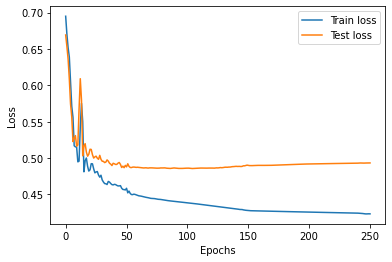

In [297]:
torch.manual_seed(42)

model = BinaryClassificationModel()

model_train(model, X_train, y_train, visualize=True)
pred = model(X_test)
get_accuracy_score(pred, y_test)

In [236]:
with torch.inference_mode():
    random_prediction = model(X_test)

random_prediction[:5], y_test[:5]

(tensor([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 6.2392e-09]),
 tensor([1., 0., 0., 1., 1.]))

In [237]:
from sklearn.metrics import accuracy_score

def get_accuracy_score(tensor_1, tensor_2):
    list_1 = [1 if item > 0.5 else int(item) for item in tensor_1]
    list_2 = [int(item) for item in tensor_2]

    return accuracy_score(list_1, list_2)

In [238]:
get_accuracy_score(random_prediction, y_test)

0.5014376078205866

In [239]:
def visualize_training(epoch_count, loss_values, test_loss_values):
    plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label='Train loss')
    plt.plot(epoch_count, test_loss_values, label='Test loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()

In [270]:
import copy

def model_train(model, X_train, y_train, visualize=False):
    torch.manual_seed(42)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 251

    epoch_count = []
    loss_values = []
    test_loss_values = []

    best_acc = - np.inf
    best_weights = None

    for epoch in range(epochs):

        if epoch == 50:
            print('changing pace')
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        if epoch == 150:
            print('Slowing down')
            optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

        model.train() # Sets parameters that require gradience to require gradient

        # Forward pass
        y_pred = model(X_train)

        # Calculate loss
        loss = loss_fn(y_pred, y_train)
        
        optimizer.zero_grad()

        # Perform backpropagation on the loss with respect to parameters
        loss.backward() # Start fresh each iteration

        # Step the optimizer (perform gradient descend)
        optimizer.step() # By default will accumulate through the loop, so zero them above

        with torch.inference_mode():
            test_pred = model(X_test)
            test_loss = loss_fn(test_pred, y_test)

            
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)

        acc = get_accuracy_score(test_pred, y_test)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())

        if epoch % 50 == 0:
            print(f'Epoch {epoch} | Loss: {test_loss}')
            print(acc)
            
    model.eval() # Turns off gradient tracking
    model.load_state_dict(best_weights)
    
    if visualize:
        visualize_training(epoch_count, loss_values, test_loss_values)

Epoch 0 | Loss: 2.492647647857666
0.5319148936170213
Epoch 100 | Loss: 0.5280230045318604
0.7682576193214491


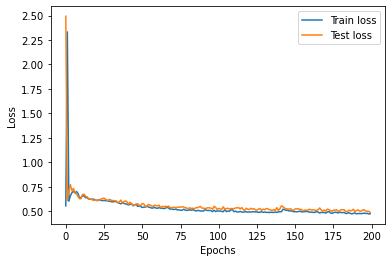

In [246]:
model_train(model, X_train, y_train, visualize=True)

In [247]:
with torch.inference_mode():
    training_prediction = model(X_test)

get_accuracy_score(training_prediction, y_test)

0.7843588269120184

In [298]:
overall_acc = []
for train, test in kfold.split(X_train, y_train):

    model = BinaryClassificationModel()
    model_train(model, X_train[train], y_train[train])
    with torch.inference_mode():
        predictions = model(X_train[test])
    acc = get_accuracy_score(predictions, y_train[test])
    print(f"Accuracy: {acc}")
    overall_acc.append(acc)

Epoch 0 | Loss: 0.6693280339241028
0.5928694652098907
changing pace
Epoch 50 | Loss: 0.48368364572525024
0.7768832662449684
Epoch 100 | Loss: 0.4867221713066101
0.7832087406555491
Slowing down
Epoch 150 | Loss: 0.49591678380966187
0.7832087406555491
Epoch 200 | Loss: 0.4964597523212433
0.7826336975273146
Epoch 250 | Loss: 0.4980427026748657
0.780333525014376
Accuracy: 0.7929547088425594
Epoch 0 | Loss: 0.6691739559173584
0.5945945945945946
changing pace
Epoch 50 | Loss: 0.4839104413986206
0.780333525014376
Epoch 100 | Loss: 0.4836820065975189
0.7832087406555491
Slowing down
Epoch 150 | Loss: 0.4953770637512207
0.7814836112708453
Epoch 200 | Loss: 0.4965231120586395
0.7832087406555491
Epoch 250 | Loss: 0.49864938855171204
0.7837837837837838
Accuracy: 0.794392523364486
Epoch 0 | Loss: 0.6688571572303772
0.6020701552616446
changing pace
Epoch 50 | Loss: 0.4999053478240967
0.7676825761932144
Epoch 100 | Loss: 0.48524582386016846
0.7786083956296722
Slowing down
Epoch 150 | Loss: 0.489568442

In [300]:
sum(overall_acc) / len(overall_acc)

0.7910556558347859